## Educational Recommender System
---

Dataset: [Open University Learning Analytics dataset](https://analyse.kmi.open.ac.uk/open_dataset)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error

In [2]:
%matplotlib inline

In [3]:
# load csv files into dataframes
assessments_df = pd.read_csv('data/assessments.csv')
courses_df = pd.read_csv('data/courses.csv')
student_assessment_df = pd.read_csv('data/studentAssessment.csv')
student_info_df = pd.read_csv('data/studentInfo.csv')
student_reg_df = pd.read_csv('data/studentRegistration.csv')
student_vle_df = pd.read_csv('data/studentVle.csv')
vle_df = pd.read_csv('data/vle.csv')

In [4]:
assessments_df, test_assessments_df = train_test_split(assessments_df, test_size=0.2, random_state=42)
courses_df, test_courses_df = train_test_split(courses_df, test_size=0.2, random_state=42)
student_assessment_df, test_student_assessment_df = train_test_split(student_assessment_df, test_size=0.2, random_state=42)
student_info_df, test_student_info_df = train_test_split(student_info_df, test_size=0.2, random_state=42)
student_reg_df, test_student_reg_df = train_test_split(student_reg_df, test_size=0.2, random_state=42)
student_vle_df, test_student_vle_df = train_test_split(student_vle_df, test_size=0.2, random_state=42)
vle_df, test_vle_df = train_test_split(vle_df, test_size=0.2, random_state=42)

In [5]:
assessments_df.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
144,FFF,2013J,34873,TMA,19.0,12.5
84,DDD,2013B,25337,TMA,116.0,15.0
98,DDD,2014B,25358,TMA,116.0,20.0
38,BBB,2014B,15017,CMA,117.0,1.0
24,BBB,2013J,15003,CMA,54.0,1.0


### Removing Bias

We need to remove certain columns in the student dataset so that recommendations out of our recommender system are not biased in any way.

We will definitely be removing
- Gender
- Region

We will be testing
- Age
- Economic Land
- Previous Attempts
- Disability 
- Number of Credits in the modules

In [6]:
student_info_df.drop(inplace=True, columns=['gender', 'region'])
student_info_df.head()

,code_module,code_presentation,id_student,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
14170,DDD,2013B,560384,Lower Than A Level,40-50%,35-55,0,60,N,Withdrawn
25301,FFF,2013J,589014,HE Qualification,60-70%,0-35,0,90,N,Pass
2862,BBB,2013J,410842,A Level or Equivalent,60-70%,0-35,0,60,N,Pass
14766,DDD,2013J,402210,No Formal quals,50-60%,0-35,0,75,N,Pass
14181,DDD,2013B,925553,HE Qualification,90-100%,55<=,0,90,N,Withdrawn


In [7]:
# divide the courses into B and J categories based on "code_presentation" because the structure of these 
# presentations is different

# student_vle_df = pd.merge(student_vle_df, vle_df, on='id_site')

# * Pre processing Assessments
courses_B_df = courses_df[courses_df['code_presentation'].str.contains('B')]
courses_J_df = courses_df[courses_df['code_presentation'].str.contains('J')]

# * Pre processing Assessments
student_assessment_df = pd.merge(student_assessment_df, assessments_df, on='id_assessment')
student_assessment_df = pd.get_dummies(student_assessment_df, columns=["assessment_type", "code_presentation"])
assessments_df.dropna(how='any', inplace=True)
assessments_df = pd.get_dummies(assessments_df, columns=["assessment_type"])
assessments_df["date"] = [int(date / 7) for date in assessments_df["date"]]
assessments_B_df = assessments_df[assessments_df['code_module'].isin(courses_B_df['code_module'])]
assessments_J_df = assessments_df[assessments_df['code_module'].isin(courses_J_df['code_module'])]

# * Pre processing VLE Dataset
# ! This gets rid of the records with no week_from and week_to values
# ! However, we are not sure if this is the right way to handle this
# * Maybe we can use the student VLE interactions to fill in the missing values
vle_df.dropna(how='any', inplace=True)
vle_df = pd.get_dummies(vle_df, columns=["activity_type"])
vle_B_df = vle_df[vle_df['code_module'].isin(courses_B_df['code_module'])]
vle_J_df = vle_df[vle_df['code_module'].isin(courses_J_df['code_module'])]

# * Pre processing Student Info Dataset
student_info_df.dropna(how='any', inplace=True)
student_info_df = pd.get_dummies(student_info_df, columns=["highest_education", "imd_band", "age_band", "disability", "final_result"])
student_info_B_df = student_info_df[student_info_df['code_module'].isin(courses_B_df['code_module'])]
student_info_J_df = student_info_df[student_info_df['code_module'].isin(courses_J_df['code_module'])]

In [8]:
def get_vle_interaction_by_site(id_site):
    """
    Returns the student vle interaction for a given site id
    """
    df = pd.DataFrame()
    df = student_vle_df[student_vle_df['id_site'] == id_site]
    return df

def get_vle_interaction_by_student(student_id):
    """
    Returns the student vle interaction for a given student id
    """
    return student_vle_df[student_vle_df['id_student'] == student_id]

def get_student_assessment_scores(student_id):
    """
    Returns the student assessment scores for a given student id
    """
    df = pd.DataFrame()
    df = student_assessment_df[student_assessment_df['id_student'] == student_id]
    return df

def get_unique_vle_sites():
    return student_vle_df['id_site'].unique()    

def calculate_euclidean_distance_student(student_id):
    """
    Returns the euclidean distance between the student and all other students
    """
    student = student_info_df[student_info_df['id_student'] == student_id]
    student = student.drop(columns=['id_student'])
    student = student.values
    students = student_info_df.drop(columns=['id_student', 'code_module', 'code_presentation'])
    students = students.values
    return np.linalg.norm(students - student, axis=1)



In [9]:
student_info_B_df.shape

(24575, 29)

### Data Exploration

We need to find trends in students' engagement with the VLE and their test scores (indication of proficiency in a topic).It would appear that  

In [10]:
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)
# find a correlation between VLE Clicks and Student assesments

def get_clicks_for_id_site_by_student(id_site, student_vle_interaction):
    """
    Returns the number of clicks for a given site id
    """
    return student_vle_interaction[student_vle_interaction['id_site'] == id_site].sum()["sum_click"]

def get_weighted_average_score(student_id):
    """
    Returns the weighted average score for a given student
    """
    assessment_scores = get_student_assessment_scores(student_id)
    assessment_scores = pd.merge(assessment_scores, assessments_B_df, on='id_assessment')
    average_score = 0
    for index, row in assessment_scores.iterrows():
        average_score += (row["weight_x"] / 100) * row["score"] 
    sum_assessment_weights = assessment_scores["weight_x"].sum()
    average_score = average_score / sum_assessment_weights
    return average_score

def corr_clicks_assessments():
    """
    Displays the correlation between VLE Clicks and Student assesments

    ! Caution: We are only analyzing the B presentations for now
    """
    clicks_assessment_scores_df = pd.DataFrame()

    SAMPLE_SIZE = 1000
    
    for index, student in tqdm(student_info_B_df.sample(n=SAMPLE_SIZE).iterrows(), total=SAMPLE_SIZE, desc="Processing Students"):
        assessment_scores = get_student_assessment_scores(student["id_student"])
        student_vle_interaction = get_vle_interaction_by_student(student["id_student"]) 
        
        assessment_scores = pd.merge(assessment_scores, assessments_B_df, on='id_assessment')
        
        sum_clicks_per_student = 0
        for id_site in student_vle_interaction["id_site"].unique():
            clicks = get_clicks_for_id_site_by_student(id_site, student_vle_interaction)
            sum_clicks_per_student += clicks

        average_score = 0
        for index, row in assessment_scores.iterrows():
            average_score += (row["weight_x"] / 100) * row["score"] 
        sum_assessment_weights = assessment_scores["weight_x"].sum()
        average_score = average_score / sum_assessment_weights
        new_row = pd.DataFrame({"sum_clicks": [sum_clicks_per_student], "average_score": [average_score]})
        if (sum_clicks_per_student < 1500):
            clicks_assessment_scores_df = pd.concat([clicks_assessment_scores_df, new_row], ignore_index=True)

    # fit a least squares line
    X = clicks_assessment_scores_df["sum_clicks"].values.reshape(-1, 1)
    y = clicks_assessment_scores_df["average_score"].values.reshape(-1, 1)

    # drop NaN values from y and drop the corresponding x values

    nan_indices = np.isnan(y)

    X = X[~nan_indices]
    y = y[~nan_indices]

    X = X.reshape(-1, 1)
    y = y.reshape(-1, 1)

    model = LinearRegression().fit(X, y)
    m = model.coef_[0][0]
    b = model.intercept_[0]

    plt.scatter(clicks_assessment_scores_df["sum_clicks"], clicks_assessment_scores_df["average_score"])
    plt.plot(X, m * X + b, color='red')
    plt.xlabel("Sum Clicks")
    plt.ylabel("Average Score")
    plt.title("Correlation between Sum Clicks and Average Score")
    plt.show()

    correlation_clicks_average_score = clicks_assessment_scores_df["sum_clicks"].corr(clicks_assessment_scores_df["average_score"])
    print(f"Correlation between Sum Clicks and Average Score: {correlation_clicks_average_score}")
    
    

# corr_clicks_assessments()

### Clicks vs Type of Content

We needed to see if the sum_clicks differ drastically based on content type in the VLE. It would appear that it does. There seems to be steep difference in the sum_clicks on "oucontent" type vs something like "dataplus". OUContent appears to be content embedded within the Open University VLE itself and the abnormally large sum_clicks could be due to a tracking deficit in other activity types.  

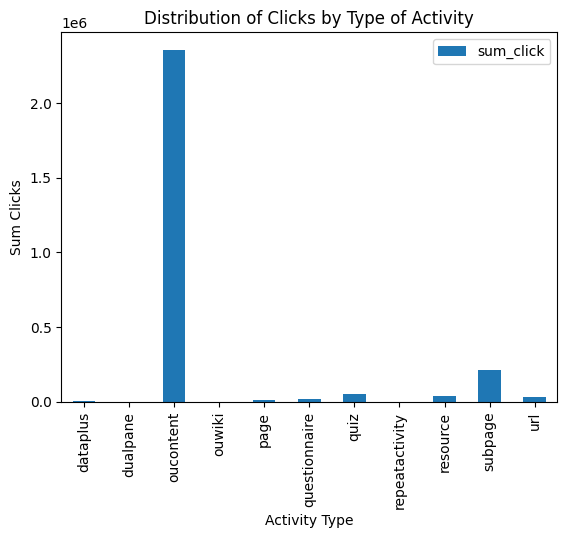

In [20]:
# Get distribution of clicks by type of activity

def show_clicks_by_type():
    """
    Displays the distribution of clicks by type of activity
    """
    global student_vle_df
    merged_vle = pd.merge(student_vle_df, vle_df, on='id_site')
    # print(merged_vle.head())
    activity_names = merged_vle.columns[10:]
    activity_names = pd.Series(activity_names)
    for i in range(len(activity_names)):
        activity_names[i] = activity_names[i].replace("activity_type_", "")
    clicks_by_type = np.zeros(shape=(len(activity_names), 1))

    # Add clicks to clicks by type based on which activity column has True
    activity_columns = merged_vle.columns[10:]
    clicks_by_type = merged_vle[activity_columns].multiply(merged_vle["sum_click"], axis="index").sum(axis=0).values
    clicks_by_type = pd.DataFrame(clicks_by_type, index=activity_names, columns=["sum_click"])

    clicks_by_type.plot(kind='bar')
    plt.xlabel("Activity Type")
    plt.ylabel("Sum Clicks")
    plt.title("Distribution of Clicks by Type of Activity")
    plt.show()

show_clicks_by_type()

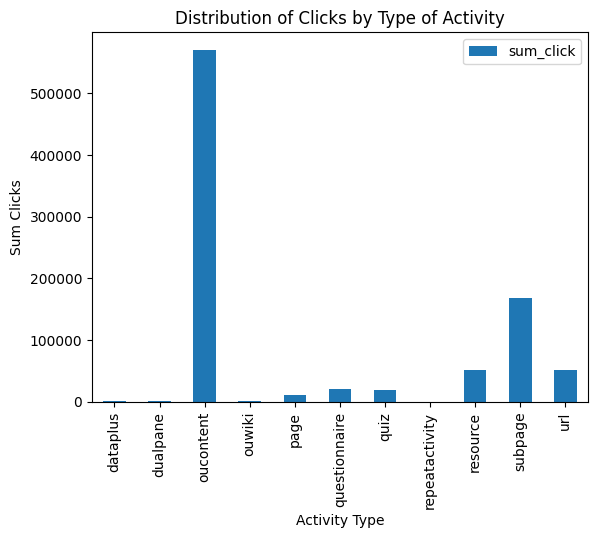

In [11]:
# Get how many of each resource is there
def get_resource_distribution():
    """
    Returns the distribution of resources
    """
    
    global student_vle_df
    # student_vle_df = pd.merge(student_vle_df, vle_df, on='id_site')
    merged_vle = pd.merge(student_vle_df, vle_df, on='id_site')
    activity_names = merged_vle.columns[10:]
    activity_names = pd.Series(activity_names)
    for i in range(len(activity_names)):
        activity_names[i] = activity_names[i].replace("activity_type_", "")
        
    activity_vectors = np.array(merged_vle.iloc[:, 10:], dtype=np.float64)
    clicks_by_type = activity_vectors.sum(axis=0)
    clicks_by_type = pd.DataFrame(clicks_by_type, index=activity_names, columns=["sum_click"])
    clicks_by_type.plot(kind='bar')
    plt.xlabel("Activity Type")
    plt.ylabel("Sum Clicks")
    plt.title("Distribution of Clicks by Type of Activity")
    plt.show()

get_resource_distribution()

In [11]:
from sklearn.linear_model import LinearRegression
import datetime
import numpy as np

# Get sucessful student ids
def get_student_assessment_trends_slope(student_info_dataframe):
    """
    Returns the ids of successful students
    Currently the heuristic is to find students with a positive slope in their assessment scores
    The slope threshold currently is 0.05 because that is the 75th percentile of the slope distribution
    """
    # plot student assessment trends
    student_assessment_df_merged = pd.merge(student_assessment_df, assessments_df, on='id_assessment')
    student_trend_df = pd.DataFrame()
    
    for index, student in tqdm(student_info_dataframe.iterrows(), total=student_info_dataframe.shape[0], desc="Processing Students"):
        student_scores = get_student_assessment_scores(student["id_student"])

        if (student_scores.empty):
            continue

        student_scores = student_scores.dropna(how='any', inplace=False)

        # calculate a linear regression line for the student scores
        x = student_scores["date"].values.reshape(-1, 1)
        y = student_scores["score"].values.reshape(-1, 1)
        if x.size == 0 or y.size == 0:
           continue 
        model = LinearRegression()
        model.fit(x, y)
        m = model.coef_[0][0]
        b = model.intercept_[0]
        if x.size > 4:
            new_row = pd.DataFrame([{"slope": m, "intercept": b, "id_student": student["id_student"]}])
            student_trend_df = pd.concat([student_trend_df, new_row], ignore_index=True)

    student_trend_df = pd.merge(student_trend_df, student_info_dataframe, on='id_student')
    return student_trend_df

def get_successful_student_trends(student_info_dataframe):
    df = get_student_assessment_trends_slope(student_info_dataframe)
    return df[df["slope"] > df["slope"].describe()["75%"]]

get_successful_student_trends(student_info_B_df) 


Processing Students: 100%|██████████| 24575/24575 [00:18<00:00, 1360.63it/s]  


,slope,intercept,id_student,code_module,code_presentation,num_of_prev_attempts,studied_credits,highest_education_A Level or Equivalent,highest_education_HE Qualification,highest_education_Lower Than A Level,...,imd_band_90-100%,age_band_0-35,age_band_35-55,age_band_55<=,disability_N,disability_Y,final_result_Distinction,final_result_Fail,final_result_Pass,final_result_Withdrawn
4,0.067627,57.182799,485671,FFF,2013J,1,150,False,False,True,...,False,True,False,False,False,True,False,False,True,False
13,0.268503,20.139415,632514,GGG,2014B,0,30,False,False,True,...,False,False,True,False,True,False,True,False,False,False
17,0.102402,70.442478,541586,BBB,2013J,0,60,True,False,False,...,False,False,True,False,True,False,True,False,False,False
18,0.206763,35.266777,339853,DDD,2014J,0,120,False,False,True,...,False,True,False,False,False,True,False,True,False,False
19,0.206763,35.266777,339853,GGG,2013J,0,30,False,False,True,...,False,True,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12499,0.097995,63.672744,609047,BBB,2013J,0,60,True,False,False,...,False,True,False,False,True,False,False,True,False,False
12501,0.130897,83.043189,2153200,BBB,2014B,0,60,True,False,False,...,True,False,True,False,True,False,False,True,False,False
12502,0.055310,75.473721,626417,CCC,2014B,0,90,False,False,True,...,False,True,False,False,True,False,False,False,False,True
12503,0.055310,75.473721,626417,DDD,2014B,0,90,False,False,True,...,False,True,False,False,True,False,True,False,False,False


In [23]:
def knn_recommender(id_student, selective_student_info_dataframe, k=5):
    """
    ### Parameters
        - id_student: The student id for which we want to find similar students
        - selective_student_info_dataframe: The dataframe containing 'successful' students

    ### Returns
        Returns the top k similar students to the given student id
    """
    student = student_info_df[student_info_df['id_student'] == id_student]
    student = student.drop(columns=['id_student', 'code_module', 'code_presentation'])
    student = student.iloc[0]
    students = selective_student_info_dataframe.drop(columns=['id_student', 'code_module', 'code_presentation'])
    student = np.array(student, dtype=float)
    students = np.array(students, dtype=float)
    distances = np.linalg.norm(students - student, axis=1)
    indices = np.argsort(distances)[:k]
    return selective_student_info_dataframe.iloc[indices]

successful_students = get_successful_student_trends(student_info_df.sample(n=50))
successful_students.drop(columns=['slope', 'intercept'], inplace=True)
knn_recommender(student_info_df.sample(n=1).iloc[0]["id_student"], successful_students, k=5)


Processing Students:   0%|          | 0/50 [00:00<?, ?it/s]

Processing Students: 100%|██████████| 50/50 [00:00<00:00, 267.11it/s]


,id_student,code_module,code_presentation,num_of_prev_attempts,studied_credits,highest_education_A Level or Equivalent,highest_education_HE Qualification,highest_education_Lower Than A Level,highest_education_No Formal quals,highest_education_Post Graduate Qualification,...,imd_band_90-100%,age_band_0-35,age_band_35-55,age_band_55<=,disability_N,disability_Y,final_result_Distinction,final_result_Fail,final_result_Pass,final_result_Withdrawn
12,633432,EEE,2014B,0,60,True,False,False,False,False,...,False,True,False,False,True,False,False,True,False,False
6,610094,FFF,2014B,0,60,False,False,True,False,False,...,False,False,True,False,True,False,False,False,True,False
0,626778,FFF,2014B,0,90,False,False,True,False,False,...,False,False,True,False,True,False,False,False,True,False


In [17]:
def prepare_DTree_data(student_features_df, resource_features_df, student_assessment_df):
    """
    Prepares the data for the Decision Tree
    
    We want to merge student features with resource features and then our target variable is the assessment score
    """

    # merge the student features with the resource features
    merged_df = pd.merge(student_features_df, resource_features_df, on='id_site')

    return merged_df

prepare_DTree_data(student_vle_df, vle_df, student_assessment_df) 

    

,code_module_x,code_presentation_x,id_student,id_site,date,sum_click,code_module_y,code_presentation_y,week_from,week_to,...,activity_type_dualpane,activity_type_oucontent,activity_type_ouwiki,activity_type_page,activity_type_questionnaire,activity_type_quiz,activity_type_repeatactivity,activity_type_resource,activity_type_subpage,activity_type_url
0,BBB,2013J,440225,704215,5,1,BBB,2013J,1.0,1.0,...,False,False,False,False,False,False,False,True,False,False
1,FFF,2014J,696318,882611,198,4,FFF,2014J,20.0,20.0,...,False,True,False,False,False,False,False,False,False,False
2,FFF,2014B,482843,779268,77,2,FFF,2014B,10.0,10.0,...,False,False,False,False,False,True,False,False,False,False
3,EEE,2014B,629753,790834,201,2,EEE,2014B,1.0,1.0,...,False,True,False,False,False,False,False,False,False,False
4,FFF,2014J,605394,882565,241,1,FFF,2014J,23.0,23.0,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896259,BBB,2014B,2513954,768478,22,1,BBB,2014B,4.0,4.0,...,False,False,False,False,False,False,False,True,False,False
896260,FFF,2014J,653773,882647,85,2,FFF,2014J,9.0,9.0,...,False,True,False,False,False,False,False,False,False,False
896261,FFF,2013J,591613,716653,-18,1,FFF,2013J,4.0,4.0,...,False,False,False,False,False,False,False,False,True,False
896262,FFF,2014J,646807,882646,54,1,FFF,2014J,8.0,8.0,...,False,True,False,False,False,False,False,False,False,False


### Association Analysis

We want to treat the resources a student consumes as items in the itemsets.

TODO:
- Create Itemsets from the resources students have consumed.
- Append relevant information to the itemsets that indicate the impact of the itemset (average [weighted] grade or grade for the assessment that those resources were used before)

In [11]:
GRADES = [0, 50, 70, 85]
def score_to_grade_bucket(score):
    """
    Converts a score to a grade bucket
    """
    if score >= GRADES[3]:
        return GRADES[3]
    elif score >= GRADES[2]:
        return GRADES[2]
    elif score >= GRADES[1]: 
        return GRADES[1]
    else:
        return GRADES[0]

def get_resource_sets_per_student(student_id):
    """
    Returns the set of resources a student has interacted with before an assessment.
    """
    global student_vle_df
    global student_assessment_df
    student_vle_interaction = get_vle_interaction_by_student(student_id)
    student_assessment = student_assessment_df[student_assessment_df['id_student'] == student_id] 
    student_vle_sets = []
    for index, assessment in student_assessment.iterrows():
        assessment_date = assessment["date_submitted"]
        student_vle_set = student_vle_interaction[student_vle_interaction["date"] < assessment_date] # ?  Say there are 3 assessments, we are saying that resources used before assessment 1 also affect the outcome of assessment 3
        student_vle_set : np.ndarray = student_vle_set["id_site"].unique()
        student_vle_set = student_vle_set.tolist()
        student_vle_set.append(score_to_grade_bucket(assessment["score"])) # ? Should I use the weighted Score?
        student_vle_sets.append(student_vle_set)
    return student_vle_sets

def get_resource_sets(sample_size = None):
    """
    Generates and returns the resource sets for all students
    """
    global student_vle_df
    global student_assessment_df

    resource_sets = []

    SAMPLE_SIZE = sample_size if sample_size is not None else student_info_df.shape[0]
    for index, student in tqdm(student_info_df.sample(n=SAMPLE_SIZE, random_state=1).iterrows(), total=SAMPLE_SIZE, desc="Processing Students"):
        student_resource_set = get_resource_sets_per_student(student["id_student"])
        resource_sets.extend(student_resource_set)
    return resource_sets

def get_resource_sets_from_file(file_name):
    """
    Reads the resource sets from a file
    """
    return pd.read_csv(file_name)

def write_sets_to_file(file_name: str, resource_sets):
    with open(file_name, 'w') as f:
        for item in resource_sets:
            for i in item:
                f.write("%s " % i)
            f.write("\n")

def get_resource_sets_from_file(file_name):
    """
    Reads the resource sets from a file
    """
    with open(file_name, 'r') as f:
        resource_sets = []
        for line in f:
            resource_set = line.split(" ")
            resource_set.pop(-1)
            resource_set = [int(resource) for resource in resource_set]
            resource_sets.append(resource_set)
        return resource_sets
    
# get_resource_sets_per_student(student_info_df.sample(n=1, random_state=1).iloc[0]["id_student"])
# len(get_resource_sets())

Observation
---

Currently I get itemsets such that a resource is considered for all assessments after it. This results in really long transaction sets. This results in really long and a lot of itemsets. This also skews support metrics in favor of resources that are perhaps used early on in the course. This is not semantically correct.

In [17]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import fpmax, association_rules
"""
    Association Analysis using mlxtend and FP Growth
"""

# ! This is conventional association analysis. We need to encode for sequential mining

def generate_rules(resource_sets):
    print(len(resource_sets))
    te = TransactionEncoder()
    te.fit(resource_sets)
    resource_sets_encoded = te.transform(resource_sets)
    df = pd.DataFrame(resource_sets_encoded, columns=te.columns_)
    df.head()

    # fpgrowth finds all frequent itemsets
    frequent_itemsets = fpgrowth(df, min_support=0.51, use_colnames=True)
    print("Frequent itemsets: ", len(frequent_itemsets))

    # association_rules finds the rules
    print("Generating Rules...")
    rules = association_rules(frequent_itemsets, num_itemsets = frequent_itemsets.shape[0],metric="lift", min_threshold=1.80)
    print(type(rules))
    rules = rules[rules['antecedents'].apply(lambda x: len(x) > 5)]   
    rules = rules[rules['consequents'].apply(lambda x: len(x) == 1)] 
    rules = rules[rules['consequents'].apply(lambda x: next(iter(x)) in GRADES)]
    return rules



resource_sets = get_resource_sets(sample_size=10)
# resource_sets = get_resource_sets_from_file('data/resource_sets.txt')   

# TODO Filter itemsets by score
# TODO print out the supports for each of the items
# TODO Account for skewed support distribution
# TODO see if you can generate closed 
# TODO See if a boolean value for 'if' the score went up

write_sets_to_file('data/resource_sets.txt', resource_sets)

rules = generate_rules(resource_sets)
rules


Processing Students: 100%|██████████| 10/10 [00:00<00:00, 177.54it/s]


49
Frequent itemsets:  131071
Generating Rules...


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f2bc2fca3c0>>
Traceback (most recent call last):
  File "/home/tanay24/miniconda3/envs/cs363m/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


: 

### Sequential Analysis
---
TODO Sequential algorithms sometimes consider A, B, C and A, B as different. So try turnign the flag off

In [20]:
from spmf import Spmf

# sp = Spmf("PrefixSpan", input_direct="data/resource_sets.txt", output_filename="output.txt", arguments=[0.1], spmf_bin_location_dir="data")
# sp.run()
# results = sp.to_pandas_dataframe()
# print(results)

In [43]:
from prefixspan import PrefixSpan

def get_frequent_sets_seq(resource_sets):
    """
    Returns the frequent sequences of resources

    ### Parameters
        - resource_sets: The sequence of resources for each student
    """
    ps = PrefixSpan(resource_sets)
    frequent_sets = ps.frequent(5, closed=True)

    filtered_frequent_sets = []
    for i in frequent_sets:
        if i[-1][-1] in GRADES:
            filtered_frequent_sets.append(i[1])
    write_sets_to_file('data/frequent_sets.txt', filtered_frequent_sets)
    return filtered_frequent_sets

def get_frequent_rules(frequent_sets):
    return generate_rules(frequent_sets)

frequent_sets = get_frequent_sets_seq(resource_sets)
frequent_rules = get_frequent_rules(frequent_sets)
write_sets_to_file('data/frequent_sets.txt', frequent_rules)


9079
